In [1]:
#JV

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym

from tqdm.notebook import tqdm
import gc
import os

### Algorithm/Approach:

1. Reset the environment
2. At every step pick an option (from pool of primitive and non-primitive actions, possible in that state - Subject to initial states of that option).
3. Option picked using e-greedy over the Q(S,.).
4. If a non-primitive option is picked, complete it to a termination state, or truncate the episode, which ever happens first. Along the option use greedy wrt Q values to pick the primitive actions.
5. Update Q values of all options in which current (primitive) action is viable. [Intra Option Learning]
6. repeat for multiple episodes till convergence (or max episodes).

gamma = 0.9 is used everywhere.


### Some observations made when I explored the environment:

    1. Dropping off or Picking up at an wrong place would not change the state, but would give a negative reward.
    2. The state is computed as an integer : ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination
        so, the row,col, PAX location and destination could be computed by reversing the above computation.
    3. The Top most row is 0th row and bottom most row is 4th row. Cols are numbered 0 to 4, from left to right.



In [3]:
class IntraOption_Qlearning:

    """
    Provides methods to perform onestep SMDP Qlearning for the "Taxi-v3" environment of Gymnasium
    
    """

    def __init__(self,non_primitive_options=4,initialization = "random",gamma=0.9,seed=76,deterministic_options=1):

        """
        Default constructor.

        Creates the Taxi-v3 env instance, and sets action, statespace variables.
        
        """

        ## set seed
        self.seed = seed
        np.random.seed(self.seed)

        ## create env object
        self.env = gym.make('Taxi-v3')
        self.env.reset(seed=self.seed, options={})
        
        ## set option and state space
        self.non_primitive_options = non_primitive_options
        self.primitive_actions = self.env.action_space.n
        self.option_space = (self.primitive_actions + self.non_primitive_options).astype(int)
        self.state_space = self.env.observation_space.n
        self.deterministic_options = deterministic_options

        if self.non_primitive_options == 4:
            ## a dictionary to attach meaning to each non-primitive option
            ## Option 6 (1st non primitive option), is about reaching the designated position 0 (R), similary for the others
            self.options_dict = {
                6 : 0,
                7 : 1,
                8 : 2,
                9 : 3
            }
        elif self.non_primitive_options == 2:
            
            ## a dictionary to attach meaning to each non-primitive option
            ## Option 6 (1st non primitive option), is to pickup the Passenger, which is the third component of the state
            ## Option 7 (second non primitive option), is to drop the passenger, which is the fourth component of the state

            self.options_dict = {
                6 : 2,
                7 : 3,
            }
            

        ## create and initialize a Q-Table
        self.initialization = initialization
        self.Initialize_Q_Table(initialization = self.initialization)

        ## Fixing gamma to be 0.9 for all experiments, as specified in PS
        self.gamma = 0.9

        ##creating results dir
        self.base_dir = "Intra_Option_Q-Learning/"

        if self.non_primitive_options==4:
            self.results_dir = self.base_dir + "Standard_Options/"
        else:
            self.results_dir = self.base_dir + "Custom_Options/"

        self.make_dir(self.base_dir)
        self.make_dir(self.results_dir)

    def make_dir(self,dir):
        try:
            os.mkdir(dir)
        except Exception as e:
            pass


    def Initialize_Q_Table(self,initialization = "random"):

        """
        Method to create a Table of size (num_states,num_options) and initialize it as specified.

        Params:
            initialization : "random" (default) or "zeros". Random is uniformly at random between (0,1).

        Returns:
            None.
        """
        
        if initialization == "zeros":
            
            self.Q = np.zeros((self.state_space,self.option_space))
        
        elif initialization == "random":
        
            self.Q = np.random.random((self.state_space,self.option_space))

    def get_coordinates(self,state):

        """
        Method to compute and return the position (row,col) of the taxi, the location of the passenger and that of the destination.

        Params:
            state : An encoded integer that is used by env to identify the states.

        Returns:
            row[0-4], col[0-4], passenger location[0-4],destination [0-3].
            
        """
    
        dst = state%4
        ploc = (state//4)%5
        col = ((state//4)//5)%5
        row = ((state//4)//5)//5
    
        return row,col,ploc,dst

    def softmax(self,vector):
        
        """
        Method to compute the probabilities proportional to the Q values.
        Vector should be a numpy array.

        Motivation : The evironment, gives an action mask with each state, a bitmap indiacting the actions feasible in that state.

        To experiment with the mask, i.e masking the actions requires making sure that all are non-negative to make sure max/argmax works well.
        Softmax because it directly gives the probabilities.

        Params:
            vector : Specifically the Q values of a particular state.

        Returns:
            softmax (array) of the vector.
        
        """

        max_val = np.max(vector)
        numerator = np.exp(vector-max_val)
        return numerator/np.sum(np.exp(vector-max_val))

    def choose_option(self,state,a_mask,epsilon,use_amask = True):

        """
        Method to pick an option during the epsiode, using e-greedy based on the q-values.
        params:
            state : the state in which an option must be picked.
            a_mask : A binary mask provided by the environment to suggest which actions are possible in a given state.
            epsilon : For epsilon greedy
            use_amask : Says if options have to be masked as per a_mask or not.

        Returns:
            the chosen option (int)
        """

        if use_amask:
            ## mask for non primitive options
            np_options_mask = np.zeros(self.non_primitive_options)
            

            ## An option can be taken if the taxi is not already in the designated position
            if self.non_primitive_options == 4:
                for opt,designated_pos in zip(self.options_dict.keys(),self.options_dict.values()):
                    if not self.env.unwrapped.locs[designated_pos] == self.get_coordinates(state)[:2]:
                        np_options_mask[designated_pos] = 1
            
            ## The mutually exclusive set of options proposed : pickup and drop
            elif self.non_primitive_options == 2:
                passenger_pos = self.get_coordinates(state)[2]
                if passenger_pos == 4: ## passenger in taxi, then pickup option masked
                    np_options_mask[1] = 1
                else: ## drop option masked
                    np_options_mask[0] = 1
                
            ## now put to gether the masks for primitive and non primitice options
            options_mask = np.concatenate((a_mask,np_options_mask))
        else:
            options_mask = np.ones(self.option_space) ## allow all options, no masking.

        ## do e-greedy
        toss = np.random.random()
        if toss<epsilon:
            option_probs = options_mask/np.sum(options_mask)
            option = np.random.choice(self.option_space,p=option_probs)
        else:
            ## argmax over softmax to make sure that complement of option mask actions are not picked
            option_probs = self.softmax(self.Q[state])*options_mask
            option = np.argmax(option_probs)

        return option

    def choose_primitive_action(self,state,a_mask,epsilon,use_amask):

        """
        Method to pick a primitive action during the during an option. epsilon greedy w.r.t Q values is used.
        This method assists the perform_option method.
        params:
            state : the state in which an option must be picked.
            a_mask : A binary mask provided by the environment to suggest which actions are possible in a given state.
            epsilon : For epsilon greedy
            use_amask : Says if options have to be masked as per a_mask or not.

        Returns:

            A primitive action.
        """

        if not use_amask:
            a_mask = np.ones(self.primitive_actions)

        toss = np.random.random() + self.deterministic_options ## if options are not determinisitic, then deterministic_options = 0 else 1
        if toss<epsilon:
            action_probs = a_mask/np.sum(a_mask)
            action = np.random.choice(list(range(self.primitive_actions)),p=action_probs)
        else:
            ## argmax over softmax to make sure that complement of option mask actions are not picked
            action_probs = self.softmax(self.Q[state][:self.primitive_actions])*a_mask
            action = np.argmax(action_probs)

        return action

    def perform_option(self,state,a_mask,cur_option,step_t,epsilon,eps_decay,eps_end,max_episode_len,use_amask,cutoff=10,alpha=0.1):

        """
        Method to apply the option to completion (or truncation) from "state" in the environment and return all relevant data.

        Params :

            state : The state in which the option is initiated.
            a_mask : The action mask provided by the environment, along with the state.
            cur_option : The currently initiated option (int).
            step_t : To maintain a global count of the epsiode length. The max episode length of 200 set by the env is respected. Step_t helps if the epsiode has less than 200 steps.
            epsilon : The current value of epsilon used for policy.
            eps_decay : The factor by which the epsilon has to be decayed.
            eps_end : The value at which epsilon stops decaying.
            max_episode_len : The maximum length of any episode. Again, 200 set by env is respected, but this helps when max epsiode length < 200 is required. 
            use_amask : True/False. If False, options are not masked, the agent can choose among all options as per its policy.
            cutoff : The Semi-Markov part :  timeout length at which option is terminated.

        Returns :

            next_state : The next state after the end of the current option.
            a_mask_next : The action mask provided by the env for the next_state.
            tot_reward : The sum of raw rewards obtained during the option (for plotting reward plot).
            step_t : The current step count in the epsiode, helps resuming.
            done : If the episode has ended/truncated.
            epsilon : The current epsilon value.
        
        
        """

        
        if cur_option in list(range(self.primitive_actions)):

            next_state, reward, done, truncated, info = self.env.step(cur_option)
            a_mask_next = info['action_mask']
            step_t += 1
            tot_reward = reward
            epsilon = max(epsilon*eps_decay,eps_end)

            self.update_Q(state,cur_option,cur_option,next_state,reward,alpha,beta = 1)


        else:

            stop = 0 ## flag variable to control stopping
            option_complete = 0 ## flag to check if the designated state is reached.

            tot_reward = 0
            option_duration = 0 
            
            while not stop:
                
                cur_action = self.choose_primitive_action(state,a_mask,epsilon,use_amask)
                next_state, reward, done, truncated, info = self.env.step(cur_action)
                a_mask_next = info['action_mask']
                
                tot_reward += reward
                
                step_t += 1
                option_duration += 1
                
                state = next_state
                a_mask = a_mask_next

                if not self.deterministic_options:
                    epsilon = max(epsilon*eps_decay,eps_end)

                beta = 0

                ## computing beta
                if self.non_primitive_options == 4:
                    designated_pos = self.options_dict[cur_option]
                    if self.env.unwrapped.locs[designated_pos] == self.get_coordinates(next_state)[:2]:
                        beta = 1

                ## The mutually exclusive set of options proposed : pickup and drop. Checking if its complete
                elif self.non_primitive_options == 2:
                    state_coordinates = self.get_coordinates(next_state)
                    if (cur_option == 6 and state_coordinates[2]==4) or state_coordinates[:2] == self.env.unwrapped.locs[state_coordinates[self.options_dict[cur_option]]]:
                        beta = 1
                
                

                self.update_Q(state,cur_option,cur_action,next_state,reward,alpha,beta=beta)

                ##checking if option has completed.

                ##checking if the current state is the designated state
                if self.non_primitive_options == 4:
                    #if not self.env.unwrapped.locs[designated_pos] == self.get_coordinates(state)[:2]:
                    if self.env.unwrapped.locs[designated_pos] == self.get_coordinates(state)[:2]:
                        option_complete = 1

                ## The mutually exclusive set of options proposed : pickup and drop. Checking if its complete
                elif self.non_primitive_options == 2:
                    state_coordinates = self.get_coordinates(state)
                    if (cur_option == 6 and state_coordinates[2]==4) or state_coordinates[:2] == self.env.unwrapped.locs[state_coordinates[self.options_dict[cur_option]]]:
                        option_complete = 1

                if done or truncated or step_t>= max_episode_len:
                    done = 1

    
                if done or option_complete or option_duration>cutoff:
                #if done or step_t >= max_episode_len or option_complete:
                    stop = 1


        return next_state,a_mask_next,tot_reward,step_t,done,epsilon

    def viable_multi_step_options_for_intra_update(self,state,cur_option,action,next_state,beta):

        """
        Intra Option Learning Idea : Upon picking an action update all options which are "consistent with action taken". 
        This method find list of all options that are consistent with the action taken. 
        "actions" Because primitive/multi-step options ultimately boil down to primitive actions.

        Params : 

            state : S_t
            cur_option : O_t (=A_t if O_t is primitive)
            action : A_t
            next_state : S_t+1 
            beta : Beta, as defined in the paper, for S_t+1

        Returns :
        
            None.

        All options options under consideration are viable in this env, provided, nest state is not the terminating state of any option.
        In that case only the corresponding option is viable, specifically because no other option would get that reward.

        
        """

        if beta == 1:

            return [cur_option]

        else:

            return list(range(self.primitive_actions,self.primitive_actions+self.non_primitive_options))

        

        

    def update_Q(self,state,cur_option,action,next_state,reward,alpha,beta):

        """
        Method to be invoked after each primitive action is applied, either during a multistep option or otherwise.

        This method performs the Intra Option Qlearning update, which is to update the Q values of all the options in which the current action is viable.

        Params:

            state : S_t
            cur_option : O_t (=A_t, if O_t is a primitive)
            action : A_t
            next_state : S_t+1
            reward : R_t
            alpha : alpha for Intra Option Q update.
            beta : Beta as defined in the paper, for S_t+1

        Returns:

            None.
            
        
        """
        
        ## updating the Q table
        ## first update the Q value for the primitive action
        Q_tilda = (1-beta)*self.Q[next_state,action] + (beta)*np.max(self.Q[next_state])
        self.Q[state,action] = self.Q[state,action] + alpha*(reward + self.gamma*Q_tilda - self.Q[state,action])
        
        ## now update q values of all the viable options, corresponding to the action take.
        
        cur_viable_options = self.viable_multi_step_options_for_intra_update(state,cur_option,action,next_state,beta)

        for viable_option in cur_viable_options:

            Q_tilda = (1-beta)*self.Q[next_state,viable_option] + (beta)*np.max(self.Q[next_state])
            self.Q[state,viable_option] = self.Q[state,viable_option] + alpha*(reward + self.gamma*Q_tilda - self.Q[state,viable_option])
        

    def train(self,alpha = 0.1,max_episodes=100,max_episode_len = 200,eps_start = 0.6,eps_decay = 0.996,eps_end = 0.01,plotting=True,use_amask=True,option_timeout_cutoff = 10):

        """
        Method to train the agent, i.e to perform one SMDP Q-Learning. (sticking to the Algo sketch given in PS).

        params:
            alpha : The learning rate.
            max_episodes : Maximum number of epiodes to train for.
            max_episode_len : Maximum number of primitive time steps per episode.
            eps_start : The begining value of epsilon.
            eps_end : The cutoff value for epsilon decay.
            eps_decay: The factor by which epsilon has to be decayed.

        Note : Epsilon decays based on global primitive time step; not using separate e-decay for the non primitive options.

        Returns:
        
            None.
        """

        ## Reset and initialize the Q table.
        self.Initialize_Q_Table(initialization=self.initialization)
        
        list_of_episode_wise_rewards = [] ## to store the total (undiscounted) reward accumulated in each episode.
        epsilon = eps_start

        for episode in tqdm(range(max_episodes)):
            #state,mask_dict = self.env.reset(seed=self.seed, options={})
            state,mask_dict = self.env.reset(options={})
            a_mask = mask_dict['action_mask'] ##action mask stating the possible PRIMITIVE actions that might be take in the state.
            
            total_reward = 0
            step_t = 0

            while step_t < max_episode_len:

                ## pick and perform the option
                cur_option = self.choose_option(state,a_mask,epsilon,use_amask) ## pick an option that is possible in the current state.
                next_state,next_a_mask,reward,step_t,done,epsilon = self.perform_option(state,a_mask,cur_option,step_t,epsilon,eps_decay,eps_end,max_episode_len,use_amask,cutoff = option_timeout_cutoff,alpha = alpha) ## its simply env.step if it is a primitive action, else it returns at the end of option.
                
                total_reward +=  reward

                state = next_state
                a_mask = next_a_mask
                
            list_of_episode_wise_rewards.append(total_reward)


        if plotting:
            plt.figure()
            plt.plot(list(range(len(list_of_episode_wise_rewards))),list_of_episode_wise_rewards)
            title = self.results_dir.split('/')[0].replace("_"," ")+" With "+self.results_dir.split('/')[1].replace("_"," ")
            plt.title(title)
            plt.xlabel('Episode')
            plt.ylabel('Total Reward')
            plt.savefig(self.results_dir+"0.png")
            plt.show()
            self.visualize_q_values()


    def plot_Q(self,Q, message = "Q plot",plot_name = "1",results_dir=""):
        
        """
        Method to plot the heat map of the Q values and the corresponding policy after training.

        The value visualized in each cell is the maximum of the Q values of all options in that state.

        Params:
            
            Q : The Q values after training.
            message : the title of the plot.
            results_dir : The directory to which results must be stored.
    
        Returns : 
            
            None
        """

        plt.figure(figsize=(7,7))
        plt.title(message)
        Q_to_plot = np.flipud(Q) ## flip the Q values array upside Down so that origin is at top left corner
        plt.pcolor(Q_to_plot.max(-1), edgecolors='k', linewidths=2)
        plt.colorbar()
        
        xlabels = [i for i in range(5)]
        ylabels = [i for i in range(5,-1,-1)]
        
        plt.xticks(np.arange(len(xlabels)),xlabels)
        plt.yticks(np.arange(len(ylabels)),ylabels)
    
        plt.savefig(results_dir+plot_name+".png")
        
        plt.show()
        plt.clf()
        plt.close('all')
        gc.collect()


    def visualize_q_values(self):
        
        """
        Method to visualize Q values as heatmaps, by generating plots for each passenger source-destination pairs.

        Params:
            None.

        Returns:
            None.
        """

        passenger_locs = list(range(5))
        destination_locs = list(range(4))

        loc_label_dict = {

            0 : "R",
            1 : "G",
            2 : "Y",
            3 : "B",
            4 : "Taxi"
        }
        
        

        plot_id = 1
        
        for ploc in passenger_locs:
            for dloc in destination_locs:
                
                passenger_loc = ploc
                destination = dloc

                ##to store the Q values corresponding to the given passenger-destination locations
                Q_viz = np.zeros((5,5,agent.option_space))
                
                for i in range(5):
                    for j in range(5):
                        state_q_vals = agent.env.unwrapped.encode(i,j,passenger_loc,destination)
                        Q_viz[i,j] = agent.Q[state_q_vals]

                if self.non_primitive_options == 4:
                    options_type = "Standard Options\n"
                else:
                    options_type = "Custom Options\n"

                message = "IntraOption Q learning With " + options_type +"Q-Values Heatmap when Passenger at "+loc_label_dict[passenger_loc]+" Destination at "+loc_label_dict[destination]+"."
                plot_name = str(plot_id)
                
                self.plot_Q(Q_viz,message,plot_name,self.results_dir)

                plot_id += 1

  0%|          | 0/14000 [00:00<?, ?it/s]

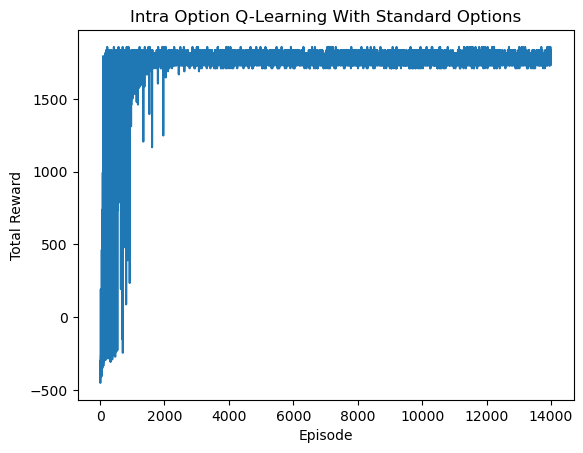

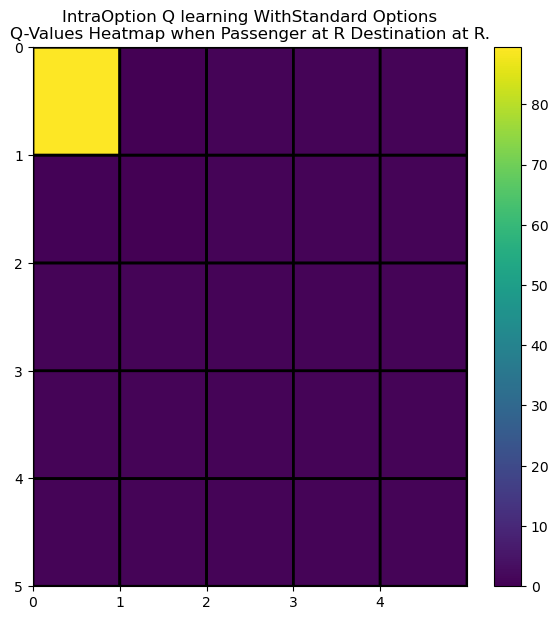

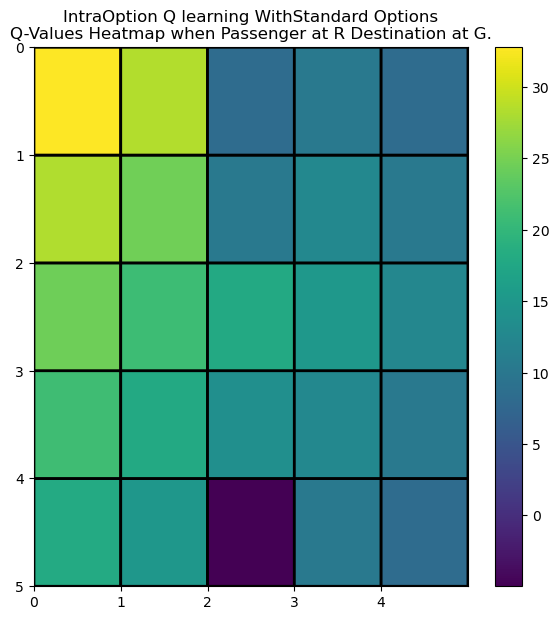

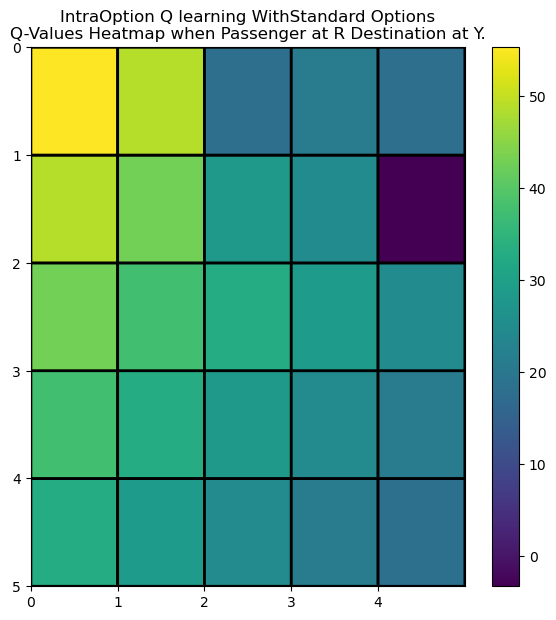

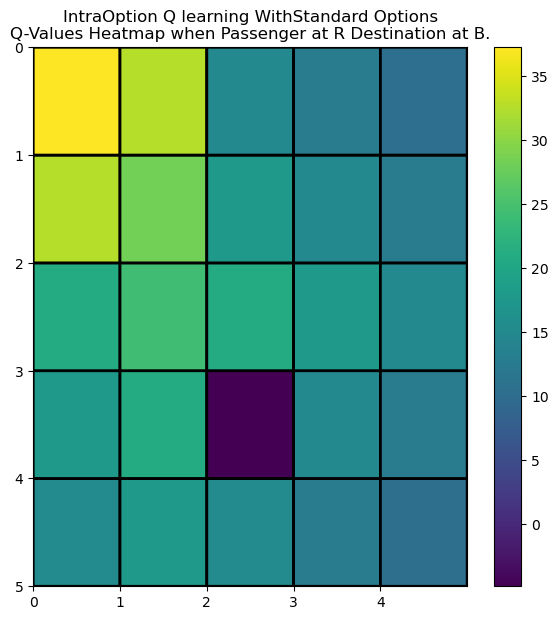

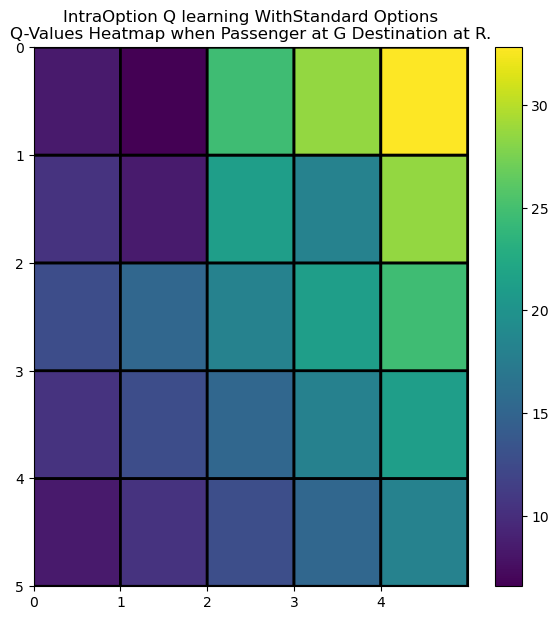

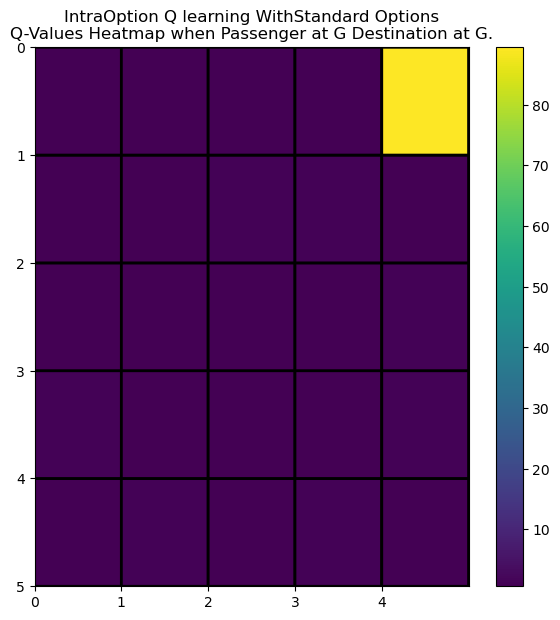

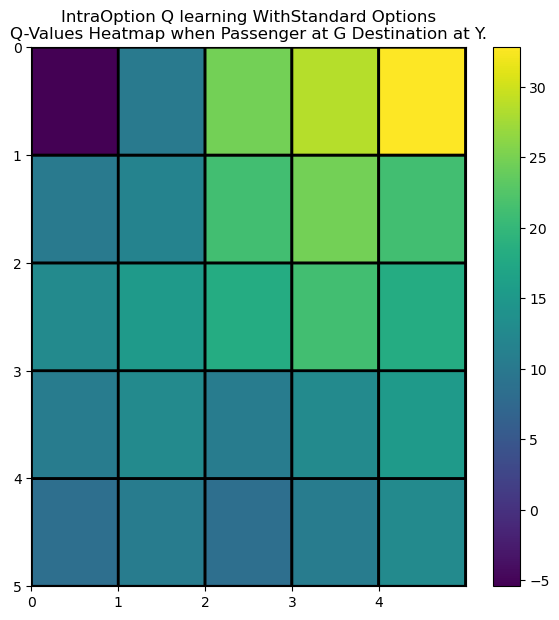

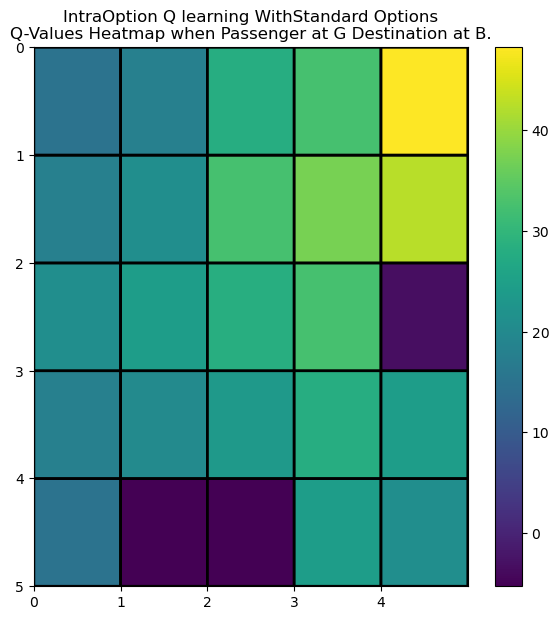

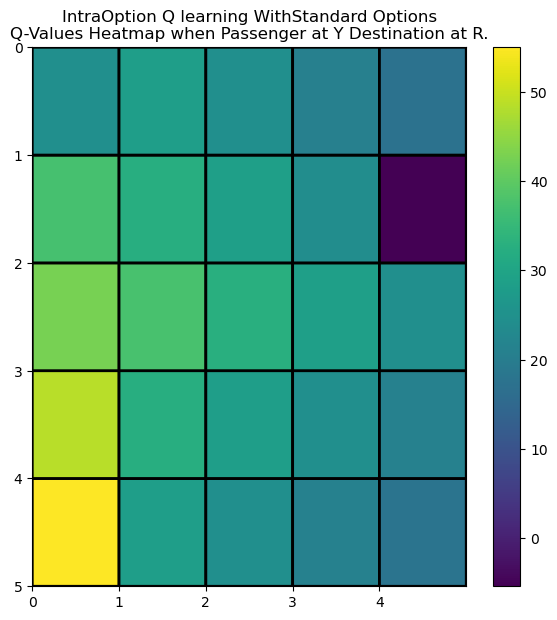

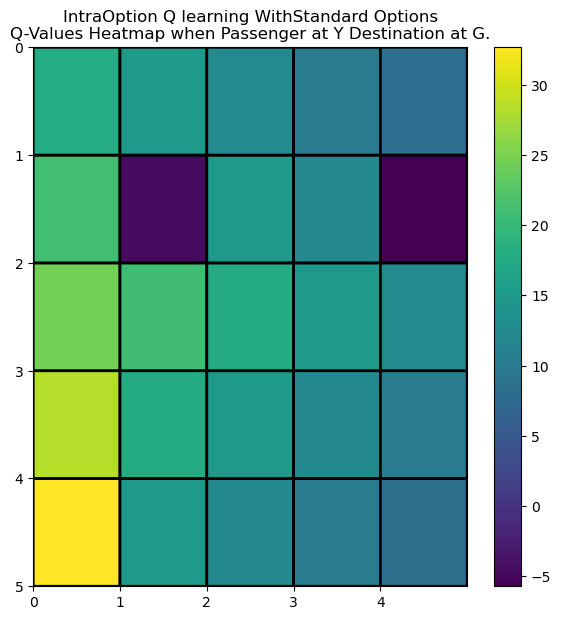

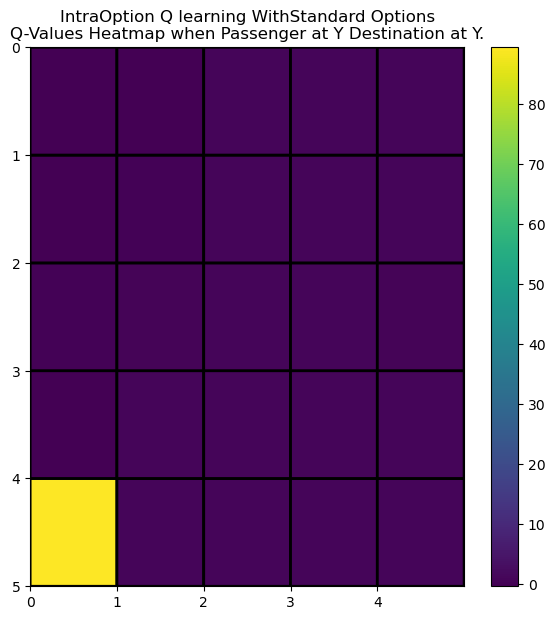

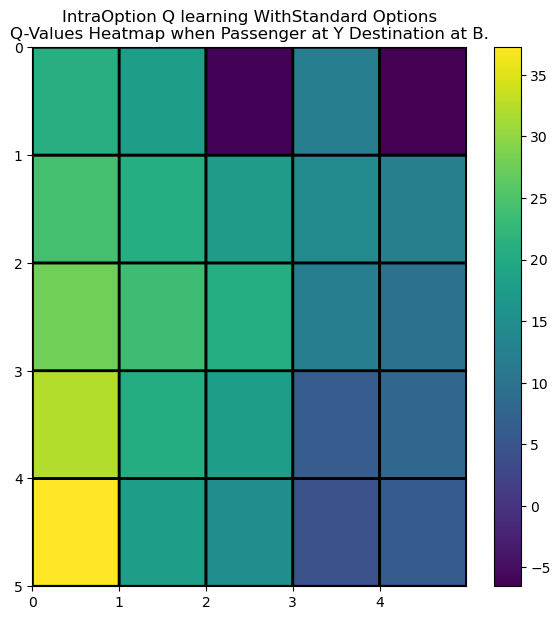

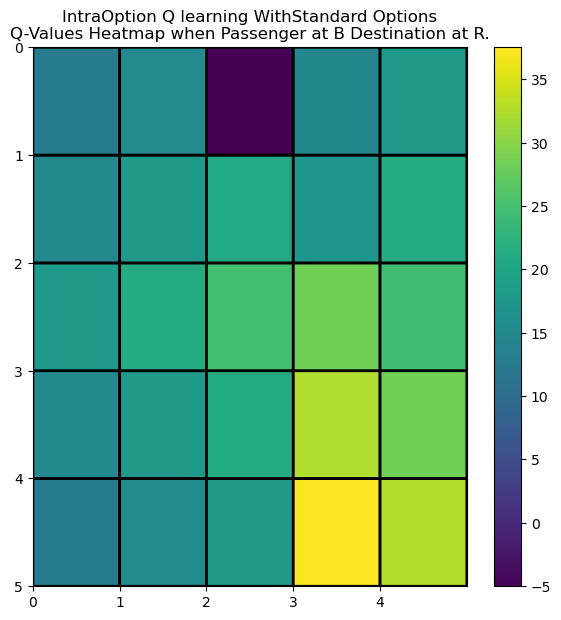

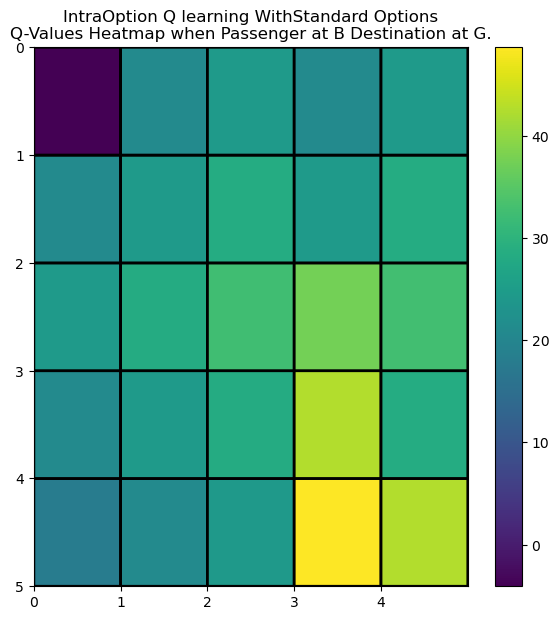

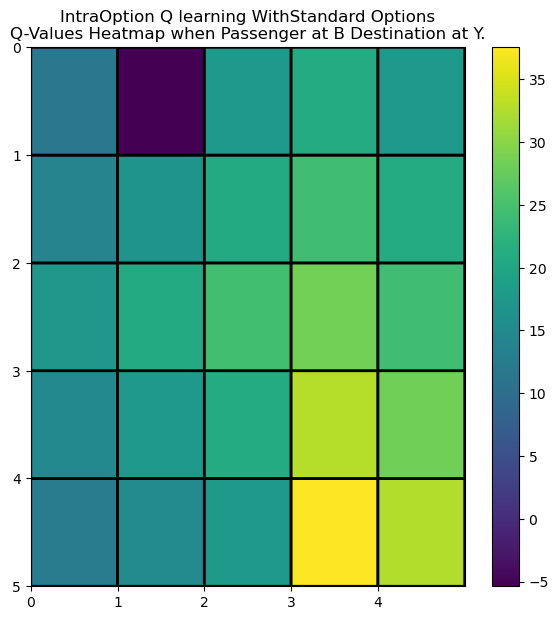

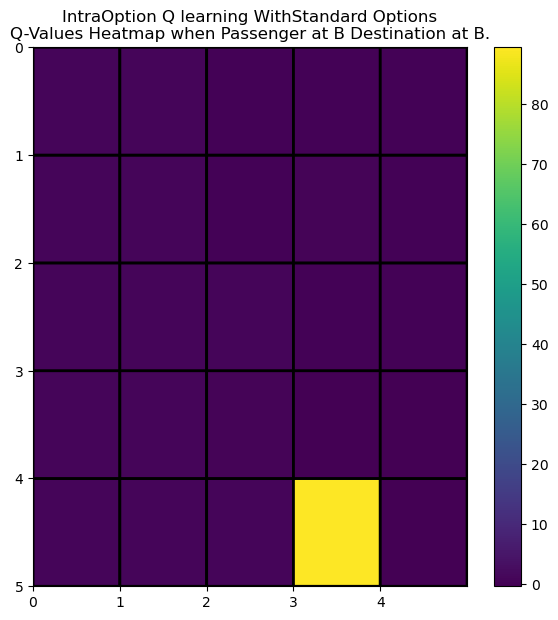

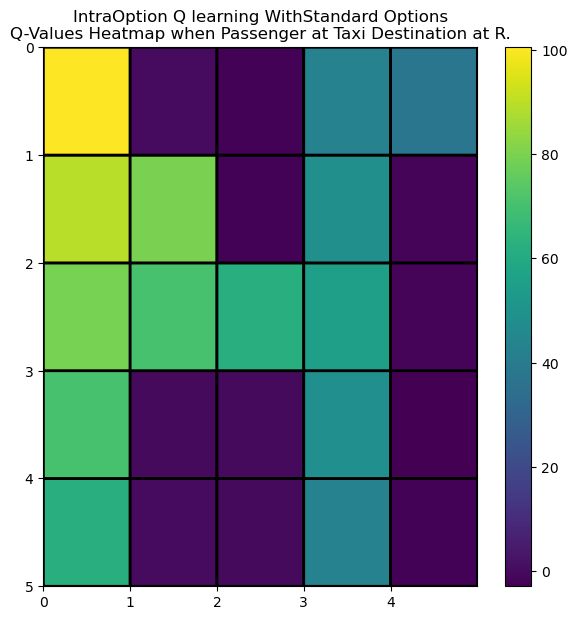

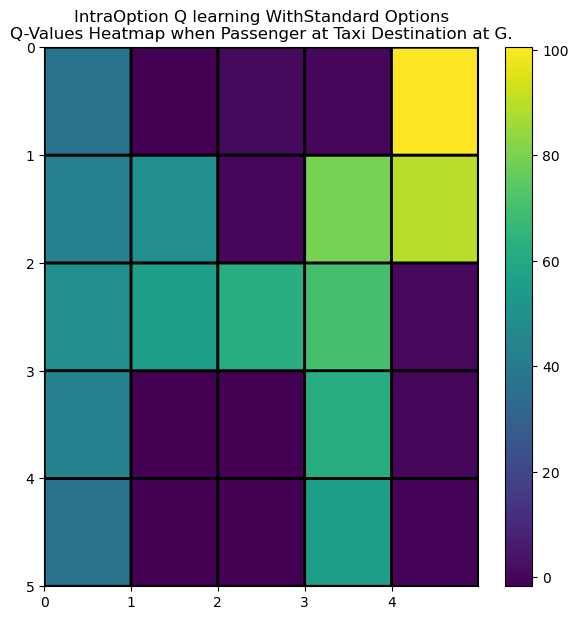

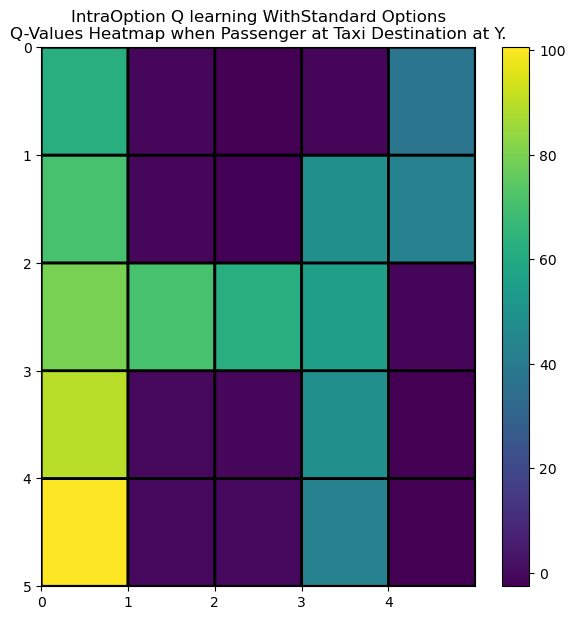

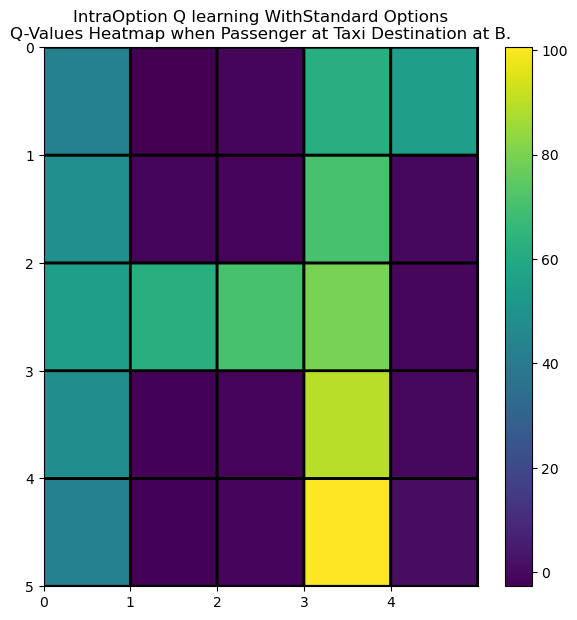

In [4]:
## Train for Standard Options
seed = 76
non_primitive_options = 4
initialization = "random"
np.random.seed(seed)
agent = IntraOption_Qlearning(initialization=initialization,non_primitive_options=non_primitive_options,seed=seed)
agent.train(alpha = 0.1,max_episodes=14000,max_episode_len = 200,eps_start = 0.1,eps_decay = 0.995,eps_end = 0,plotting=True,use_amask=False,option_timeout_cutoff=9)

  0%|          | 0/14000 [00:00<?, ?it/s]

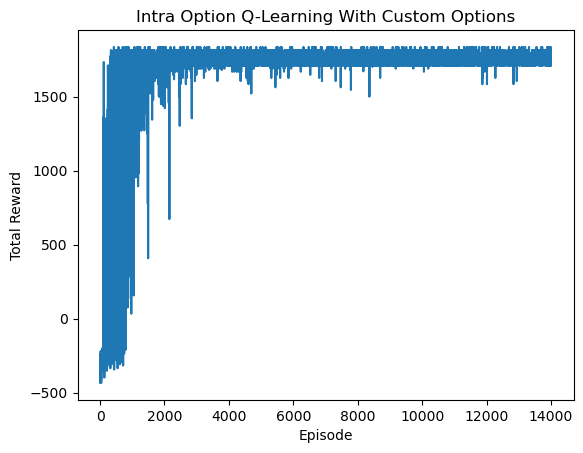

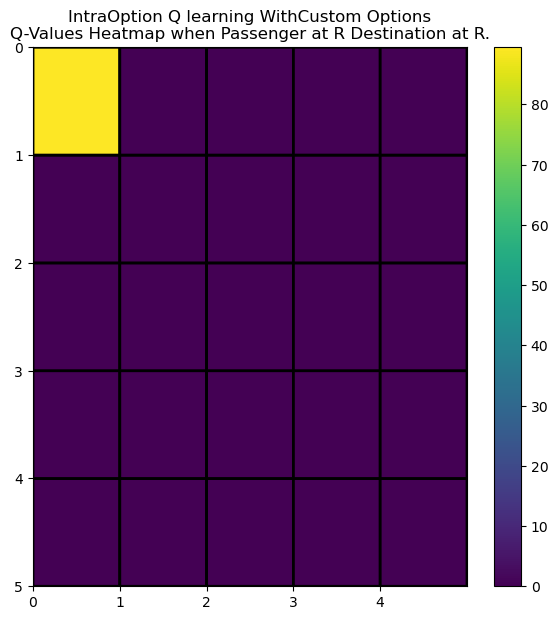

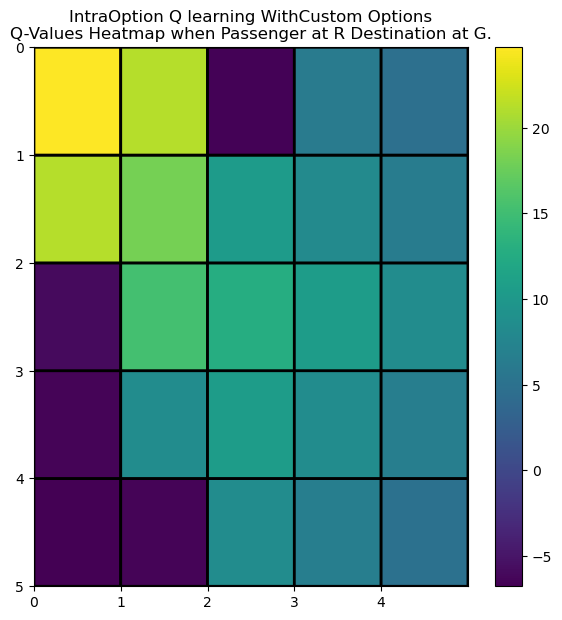

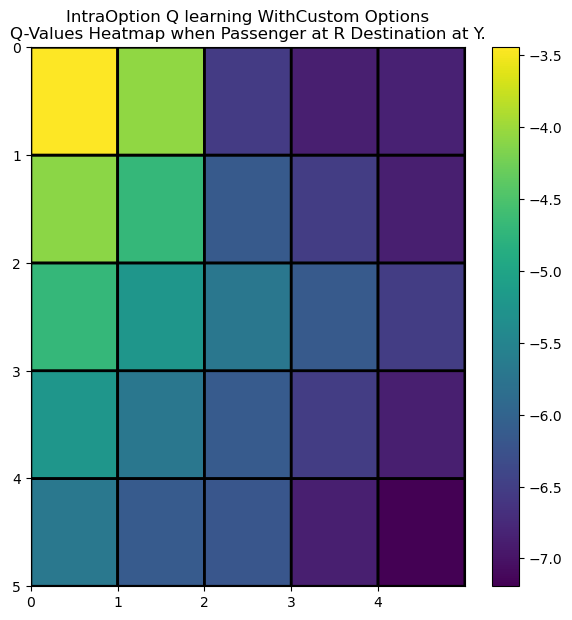

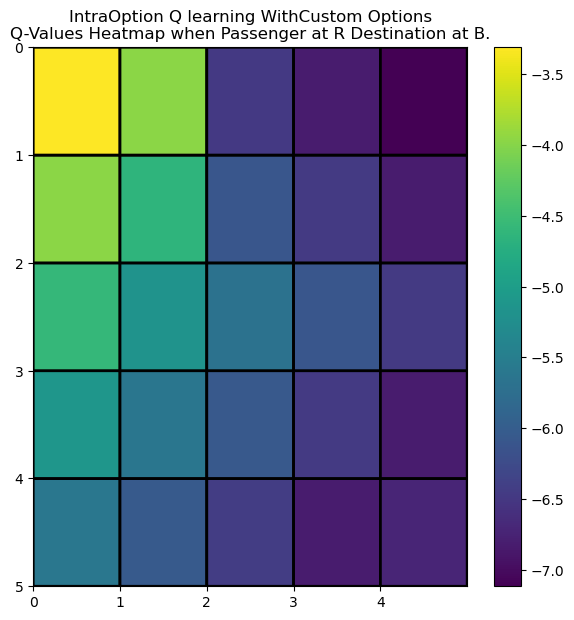

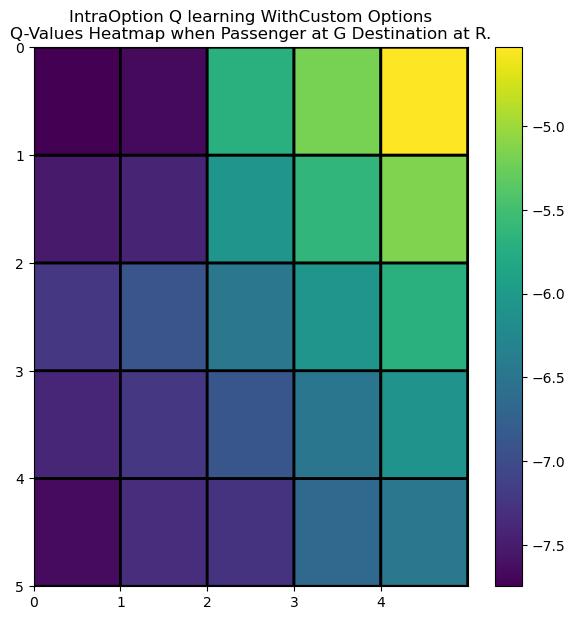

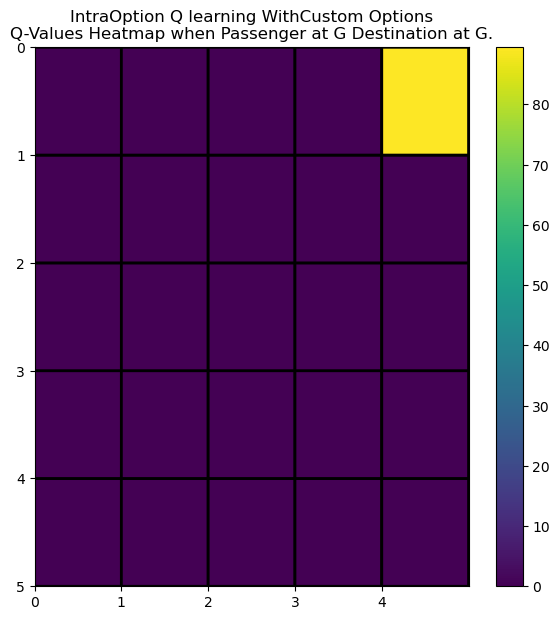

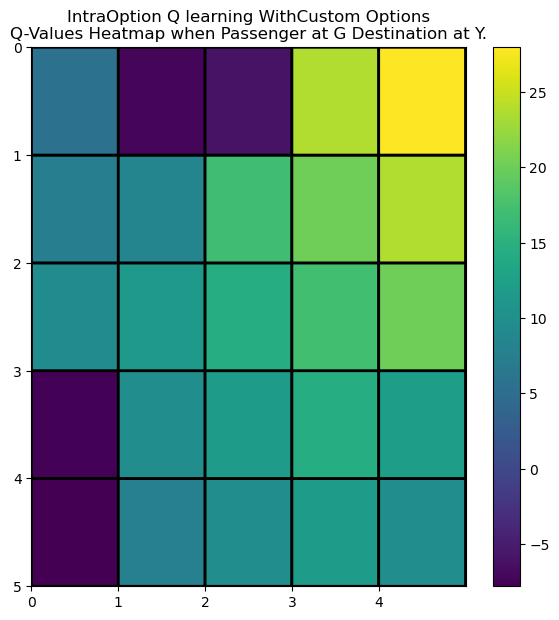

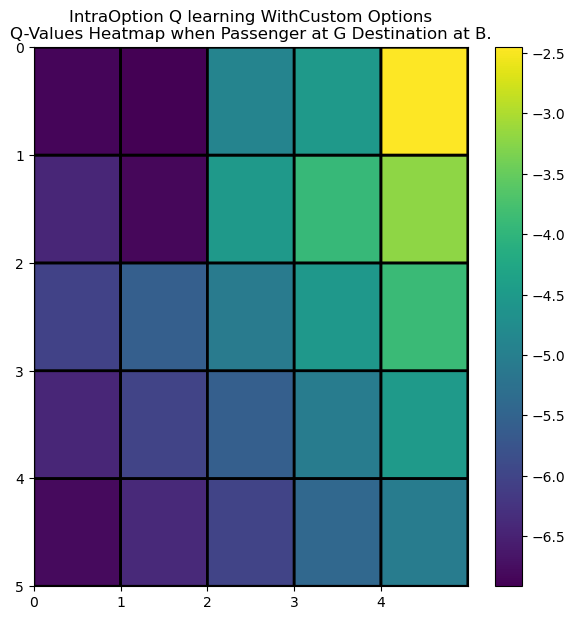

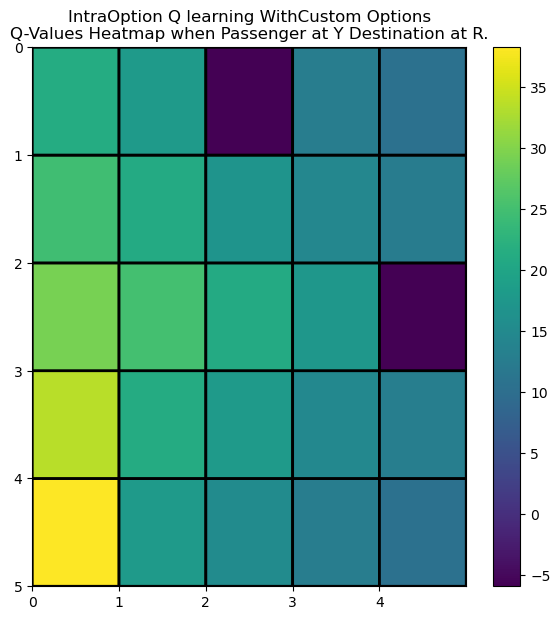

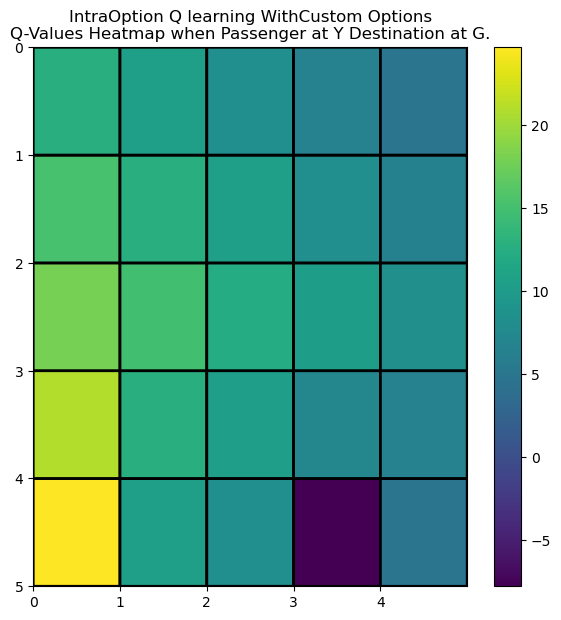

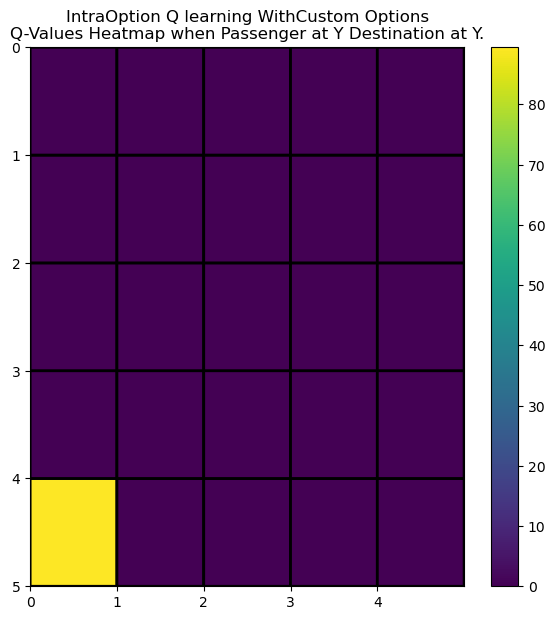

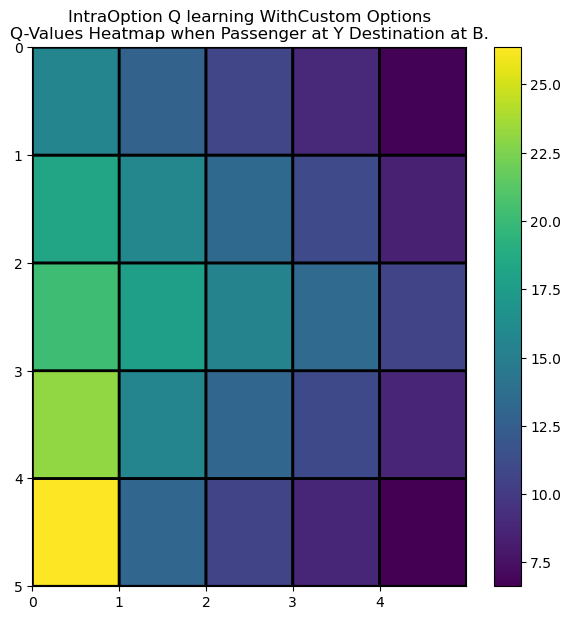

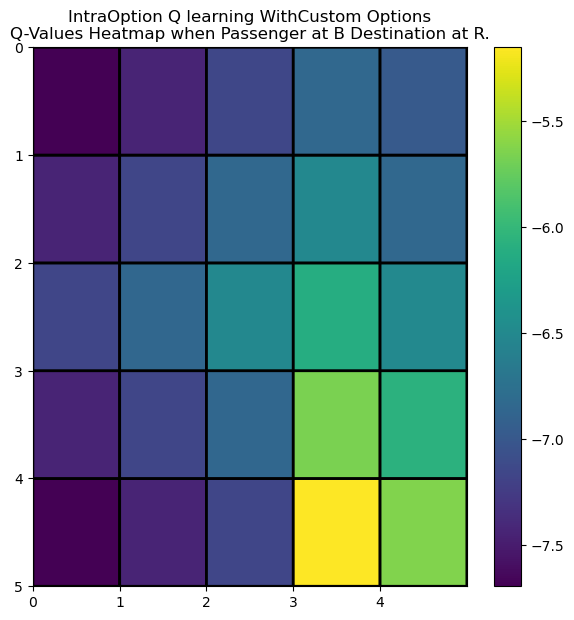

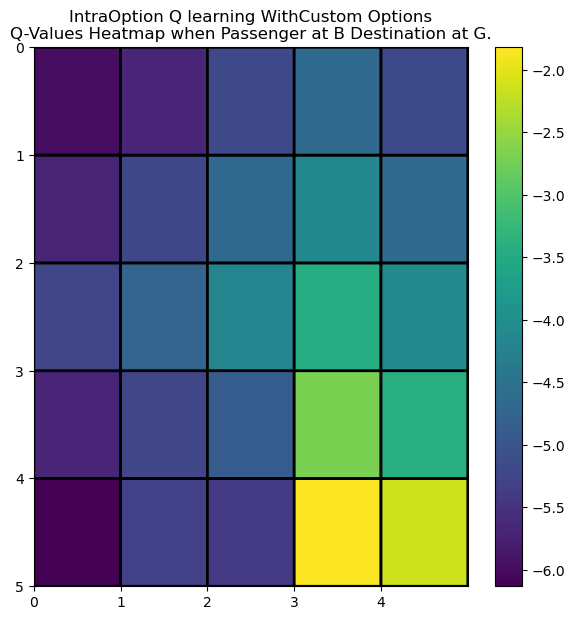

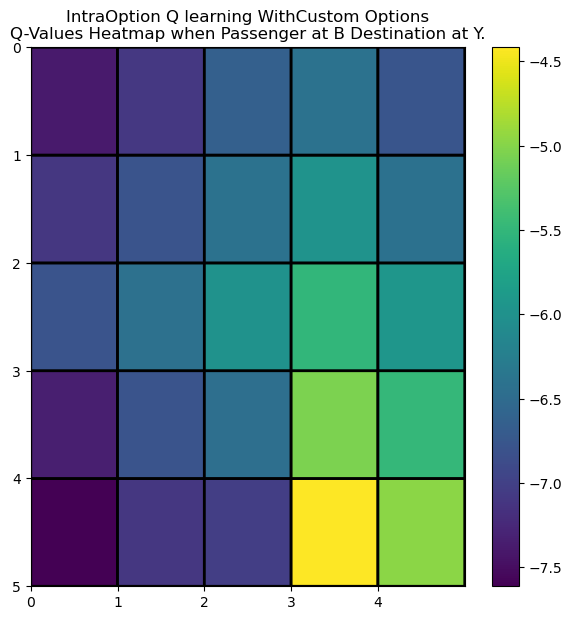

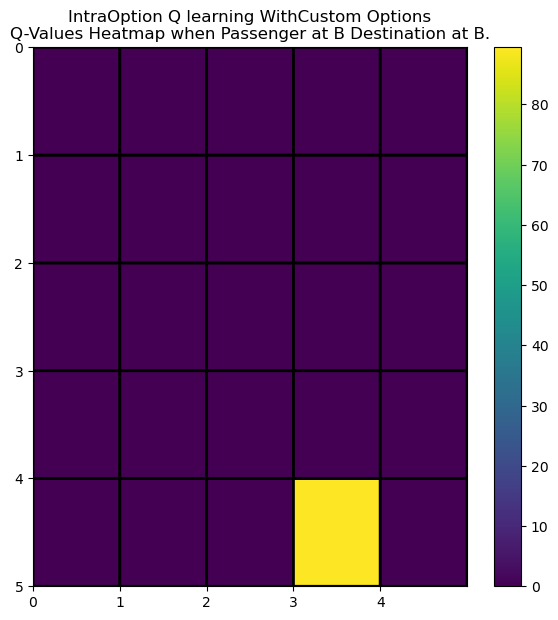

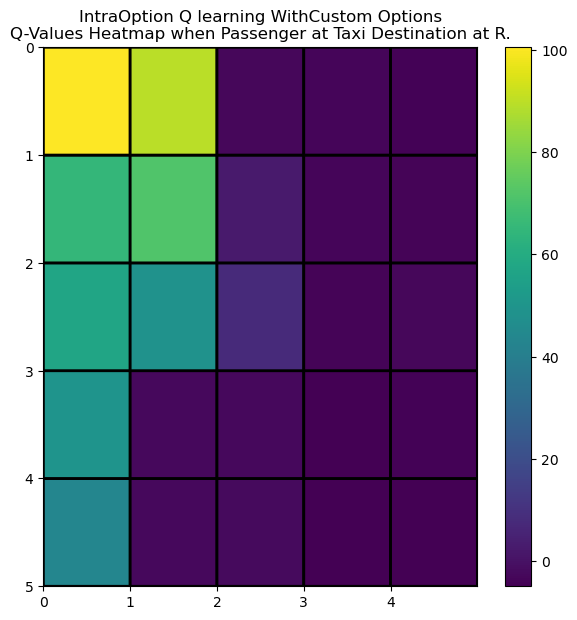

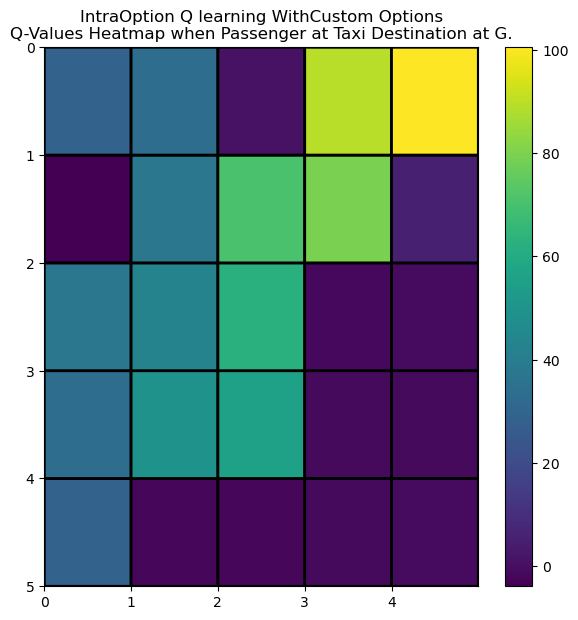

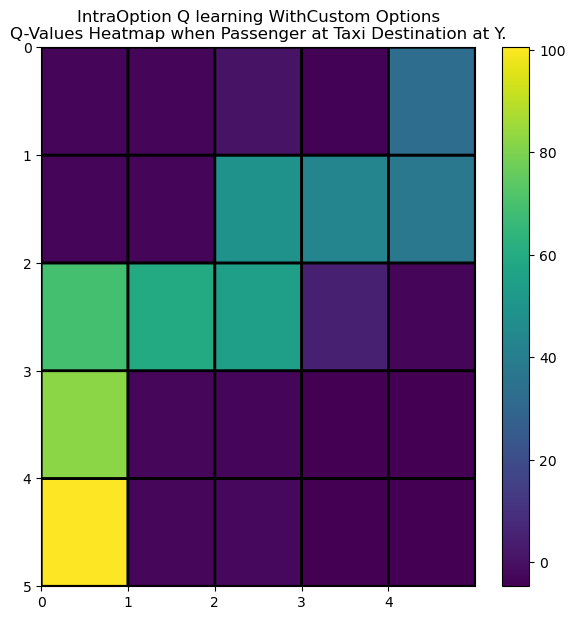

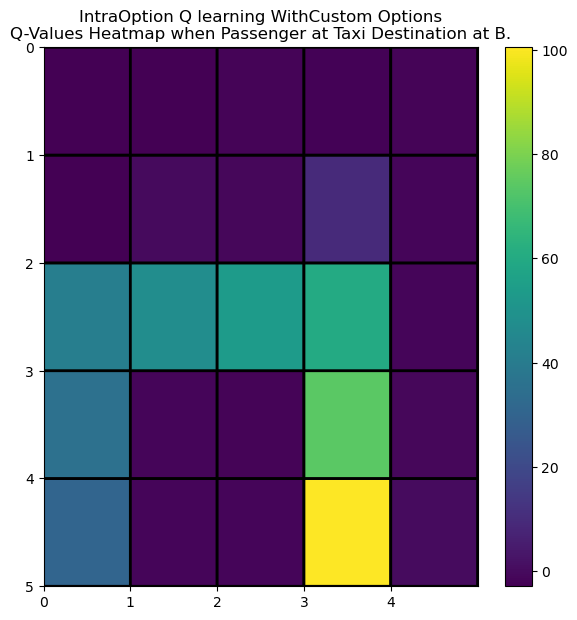

In [5]:
## Train for Custom Options
seed = 76
non_primitive_options = 2
initialization = "zeros"
np.random.seed(seed)
agent = IntraOption_Qlearning(initialization=initialization,non_primitive_options=non_primitive_options,seed=seed)
agent.train(alpha = 0.1,max_episodes=14000,max_episode_len = 200,eps_start = 0.1,eps_decay = 0.995,eps_end = 0,plotting=True,use_amask=False,option_timeout_cutoff=10)

In [ ]:
"""
Intraoption learning update has to be applied to all the options at which that, might have chosen the correct action or option.

Update can be done for all primitive options directly and 
for multistep options as per:

## An option can be taken if the taxi is not already in the designated position
            if self.non_primitive_options == 4:
                for opt,designated_pos in zip(self.options_dict.keys(),self.options_dict.values()):
                    if not self.env.unwrapped.locs[designated_pos] == self.get_coordinates(state)[:2]:
                        np_options_mask[designated_pos] = 1
            
            ## The mutually exclusive set of options proposed : pickup and drop
            elif self.non_primitive_options == 2:
                passenger_pos = self.get_coordinates(state)[2]
                if passenger_pos == 4: ## passenger in taxi, then pickup option masked
                    np_options_mask[1] = 1
                else: ## drop option masked
                    np_options_mask[0] = 1

"""


        """
        We can only make use of rewards upon S,A, not change them.

        When next_state is goal/termination of an option, that action is not vaiable in options with a different termination condition
        because reward upon termination would be different from that of a regular action.
        
        """

        """option_terminations = [] ##to know list of options for which the current transition is towards termination

        if self.non_primitive_options == 4:
            for opt,designated_pos in zip(self.options_dict.keys(),self.options_dict.values()):
                if self.env.unwrapped.locs[designated_pos] == self.get_coordinates(next_state)[:2]:
                    option_terminations[designated_pos] = 1

            terminating_options = np.nonzero(option_terminations)[0]
    
            if terminating_options.shape[0]>0: ## if there are terminating options
                return terminating_options
            else:
                return np.array(range(6,6+self.non_primitive_options))

        elif self.non_primitive_options == 2:
            
            passenger_pos = self.get_coordinates(next_state)[2]
            if passenger_pos == 4: ## passenger in taxi
                return np.array([6])
            else: 
                return np.array([7])"""

In [ ]:
"""
1. Masking code (action masks) was written just to try out how learning happens if the masks given by the environment are used. It turned out to be bad.

2. To support the masking code softmax was applied to q values and masked to get probs. Other wise masked (0ed) q values may dominate if the other q values are negative.

3. When the environment truncates an episode, the trainining loop respects that, but the max_episode_len is to try out values less than 200

4. The idea of cutoff on option duration, is helping greatly in training and infact is the whole motiviation for semi-markov options over markov options.s

"""

In [ ]:
x = np.array([0,1,0,0,1,1,0,0])

(np.nonzero(x)[0]+5)

In [ ]:
np.array(range(5))

In [ ]:
"""
Dry run over the code once again.

Complete reading SMDP planning and also mahadev's paper. Also the intra-options paper.

=>See tutorial

Dry run over the code once.

=> All good : Hyperparameter tuning.

"""

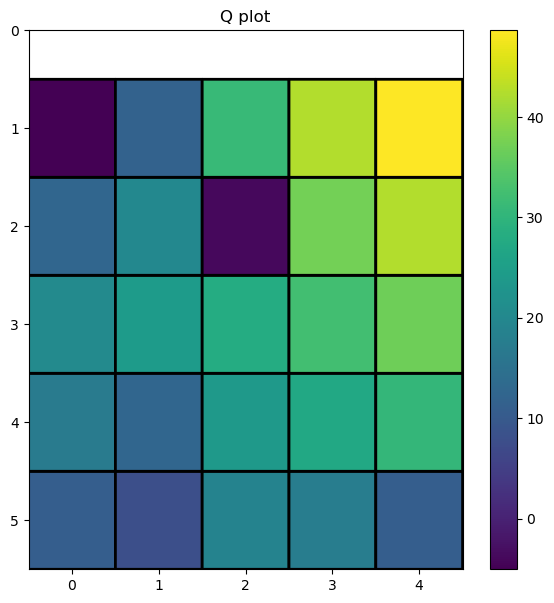

In [49]:
passenger_loc = 0
destination = 1

Q_viz = np.zeros((5,5,agent.option_space))

for i in range(5):
    for j in range(5):
        state_q_vals = agent.env.unwrapped.encode(i,j,passenger_loc,destination)
        Q_viz[i,j] = agent.Q[state_q_vals]

agent.plot_Q(Q_viz)

In [ ]:
"""
1. Read Mahadavan paper on SMDP Qlearning
2. Read about intra-option q learning
3. correct the update rules for any mistakes.
4. Go through the code, do hyperparam tuning
5. Create report.

"""

### Algorithm/Approach:

1. Reset the environment
2. At every step pick an option (from pool of primitive and non-primitive actions, possible in that state - Subject to initial states of that option).
3. Option picked using e-greedy over the Q(S,.).
4. If a non-primitive option is picked, complete it to a termination state, or truncate the episode, which ever happens first. Along the option use e-greedy to pick the primitive actions.
5. repeat for multiple episodes till convergence (or max episodes).

gamma = 0.9 is used everywhere.